In [1]:
#Import Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Introduction
Throughout history one of the deadliest diseases humanity has faced is malaria. It was dubbed the "single biggest killer of humans in history" by the YouTube channel, 'Kurzgesagt - In a nutshell', who published a great video on its transmission and the ways scientists today are trying to fight it. However, before any treatment plan can be recommended the infection needs to identified and the condition diagnosed. This fact, combined with the disease’s severity and prevalence, means that an accurate, fast, and inexpensive detection method should be available to everyone and not just people from first world countries. 

The CDC recognizes this, and recommends malaria be promptly treated to prevent further spread in the community as well as to prevent severe disease and potentially death for the patient. However, at the same time they highly discourage "presumptive treatment" (treatment without a confirmed diagnosis,) as overuse of antimalarial drugs may lead to drug-resistant strains as well as unwanted side effects for the patient.

Diagnostic tests can be performed through either blood smear microscopy or PCR testing. PCR testing is more sensitive and specific than microscopy, but the testing is more expensive, and the results are not available as fast as microscopy. 

Because of this, it is proposed that as part of a standard medical screening for populations in high-risk areas of malaria that a portion of blood drawn be devoted to an automated batch microscopy scanning by computer. Automating the task means testing could be implemented for large population sizes at little cost and only requiring minimal personnel with no more than technician level training. Outbreaks could be identified early, and human incurred disability could be minimized.

This could be implemented using machine learning and artificial neural networks. To show the feasibility, a model CNN will be trained using a small data set and only minimal computer resources. The dataset used in training the model contains images of blood cell slides with and without parasitic infection. Before real-world implementation, a larger dataset and additional training processor-hours would be required. However, even on this small scale the results prove promising. A well-trained model hosted in the cloud could potentially enable any cellphone with an internet connection to function as a malaria testing device.


Stained thin blood smear slides from 150 infected and 50 healthy patients were collected and photographed by the  Chittagong Medical College Hospital in Bangladesh. These
The data with images of infected blood cells, as well as uninfected blood cells. Our goal is to create a model that can differentiate between the two. Let's visualize the two side-by-side:


Sources:

Rajaraman S, Antani SK, Poostchi M, Silamut K, Hossain MA, Maude RJ, Jaeger S, Thoma GR. 2018. Pre-trained convolutional neural networks as feature extractors toward improved malaria parasite detection in thin blood smear images. PeerJ 6:e4568 https://doi.org/10.7717/peerj.4568 

https://www.youtube.com/watch?v=TnzcwTyr6cE

https://www.cdc.gov/malaria/diagnosis_treatment/clinicians1.html#eval




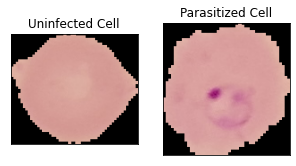

In [2]:
#Setting paths
test_path = 'cell_images/test'
train_path = 'cell_images/train'

#Grabbing single images to view
uninfected_cell = 'cell_images/train/uninfected/C100P61ThinF_IMG_20150918_144104_cell_128.png'
para_cell = 'cell_images/train/parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png'

plt.figure(1, figsize = (5 , 3))
plt.subplot(1 , 2 , 1)
plt.imshow(imread(uninfected_cell))
plt.title('Uninfected Cell')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(imread(para_cell))
plt.title('Parasitized Cell')
plt.xticks([]) , plt.yticks([])

plt.show()

# Data Preprocessing
In order to fit a CNN model we need to make sure the dimensions (width & height) of each image are the same. Below, we will check the dimensions of all images, and then choose a final dimension to apply to all images prior to training the model. Having the same input picture size is important, as this determines the architecture of our CNN model. From the joint distribution plot below, we see that most pictures have height and width of around 130 pixels, so this is the reshaping size we select.

In [3]:
#check dimensions
dim1 = []
dim2 = []

for image_filename in os.listdir("cell_images/test/parasitized"):

    img = Image.open("cell_images/test/parasitized/"+image_filename)
    d1, d2 = img.size
    dim1.append(d1)
    dim2.append(d2)

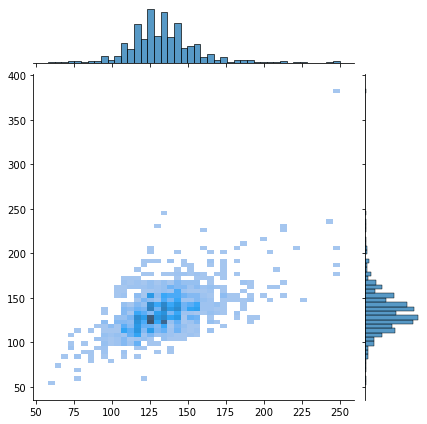

In [4]:
#we have some small images, some large ones
sns.jointplot(x=dim1,y=dim2, kind='hist')

In [5]:
#Resize to
image_shape = (130,130,3)

<h3>Adding Augmented Images</h3>
CNN models need a lot of training images to be able to create robust models. Instead of collecting more blood cells from people, we can create augmented data points using existing images by applying transformations on them, such as rotation or resizing them. Below you can see an original picture next to a slightly modified one.

In [6]:
#To increase data points augment existing data
#Create more blood cell images with resize, rotation etc
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(rotation_range=20,#randomyl rotate 0-20 degrees
                               width_shift_range = 0.10,#0.10: randomly change size using 0-10%
                               height_shift_range=0.10,#0.10: randomly change size using 0-10%
                               shear_range=0.10,
                               zoom_range=0.10,
                               horizontal_flip=True,
                               rescale=1/255,
                               fill_mode='nearest')

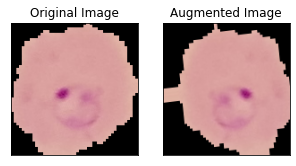

In [7]:
para_img = imread(para_cell)

plt.figure(1, figsize = (5 , 3))
plt.subplot(1 , 2 , 1)
plt.imshow(para_img)
plt.title('Original Image')
plt.xticks([]) , plt.yticks([])

plt.subplot(1 , 2 , 2)
plt.imshow(image_gen.random_transform(para_img))
plt.title('Augmented Image')
plt.xticks([]) , plt.yticks([])

plt.show()

In [8]:
#apply transformation to data set to artificially expand dataset
image_gen.flow_from_directory(train_path)

Found 24958 images belonging to 2 classes.


# Modeling

Convolutional Neural Net (CNN) models are great at image recognition and widely used for this task. CNN's scan over an image using a filter, usually 3x3 pixels, and determine how similar the current image scan area is to the filter. This helps them perform better at image recognition since they are looking at a region of NxN pixels, vs one pixel, so they can pick up on correlations in images. In contrast, if a regular neural net model were fit to an image, it would skip the feature extraction process, and just save the image inputs as a flattened layer using their pixel values as is. This would lead to loss of nearby pixel information, as well as make the input layer much larger (NxN).


![CNN Architecture](https://raw.githubusercontent.com/MnNqB/Malaria_CNN/main/CNN%20Architecture_MNB.PNG)

This model has three convolutional layers, each using rectified linear activation units (ReLU). The convolutional layer applies different filters to try and detect patterns, and outputs a feature map (dot product). The ReLU activation returns only positive values while setting any negative dot products to zero. ReLU activations are widely used because they are more computationally efficient and show better convergence performance than other activation functions, such as the sigmoid function. Each convolutional layer's output is fed into a pooling layer. Next, a Max Pooling layer is applied, which only keeps the maximum output from each quarter of the feature map. This reduced output is fed into the next layer, and eventually to the dense layer.

To demonstrate a simple image and filter convolution, see CNN hand calculation below. A random filter is selected and applied using a dot product to the picture. A bias term is added, and the final value is added to the feature map. The process is started over after making the appropriate stride. In this model the stride is set to the default of 1.

![CNN hand calc](https://raw.githubusercontent.com/MnNqB/Malaria_CNN/main/CNN%20Example1.gif)

This makes it easy to see how information from a large picture can be compressed down using CNNs. A regular neural net would have fed all 36 pixels to the dense layer, whereas this approach only feeds just 4. Real images are sized a lot more than 6x6, so CNN’s scale much better for real images.

Once the image and filter dot product is calculated, a bias term is added. Once this is done across the whole image the feature map is done. Next, the ReLU activation is applied which sets any negative numbers to zero. Finally, max pooling is applied followed by the flattening layer, which outputs all values into one column (vector). This is what gets fed into the Dense (neural net) layer. 


![CNN Hand Calc2](https://raw.githubusercontent.com/MnNqB/Malaria_CNN/main/CNN%20Example2.gif)


For more information please check out 'StatQuests' video on CNNs: 
https://www.youtube.com/watch?v=HGwBXDKFk9I&t=599s

In [9]:
#Creating the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape,activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

model.add(Dense(128,activation='relu'))

# randomly turn off 20% of neurons to reduce overfitting by randomly turning neurons off during training.
model.add(Dropout(0.2))

# binary: use sigmoid
model.add(Dense(1,activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

In [10]:
#Early stopping monitors the fit each loop and terminates training if the loss on the test set is no longer decreasing
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

#training batch size
batch_size = 32

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 128)       7

In [12]:
#generate additional images for training
#image_shape[:2] because we only want dim1,dim2, not c from shape
train_image_gen = image_gen.flow_from_directory(train_path,target_size=image_shape[:2],
                                                color_mode='rgb',batch_size=batch_size,
                                                class_mode='binary')

Found 24958 images belonging to 2 classes.


In [13]:
#generate additional test images
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


# Training

In [14]:
results = model.fit(train_image_gen,epochs=20,
                              validation_data=test_image_gen,
                              callbacks=[early_stop])

2021-12-23 07:37:00.206491: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2021-12-23 07:37:03.273748: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


862/862 [==============================] - 377s 428ms/step - loss: 0.6280 - accuracy: 0.6584 - val_loss: 0.5696 - val_accuracy: 0.7263
Epoch 2/20
862/862 [==============================] - 235s 273ms/step - loss: 0.5540 - accuracy: 0.7340 - val_loss: 0.5185 - val_accuracy: 0.7527
Epoch 3/20
862/862 [==============================] - 234s 272ms/step - loss: 0.4777 - accuracy: 0.7872 - val_loss: 0.4058 - val_accuracy: 0.8200
Epoch 4/20
862/862 [==============================] - 233s 271ms/step - loss: 0.3494 - accuracy: 0.8546 - val_loss: 0.2928 - val_accuracy: 0.8706
Epoch 5/20
862/862 [==============================] - 237s 275ms/step - loss: 0.2699 - accuracy: 0.8842 - val_loss: 0.2434 - val_accuracy: 0.8877
Epoch 6/20
862/862 [==============================] - 236s 274ms/step - loss: 0.2357 - accuracy: 0.9017 - val_loss: 0.2356 - val_accuracy: 0.8984
Epoch 7/20
862/862 [==============================] - 238s 276ms/step - loss: 0.2220 - accuracy: 0.9128 - val_loss: 0.2113 - val_accura

# Model Evaluation

This simple CNN model achieved over 93% accuracy on the test images, and was still seeing improvements based on the declining loss function. The confusion matrix shows that the model achieved a recall score of 92% for detecting a parasitized cell (0).

In [15]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

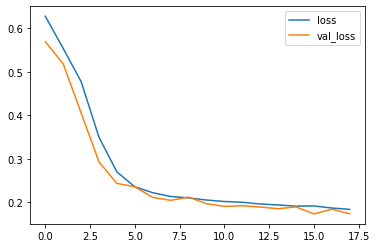

In [16]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

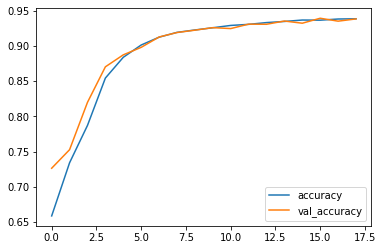

In [17]:
losses[['accuracy','val_accuracy']].plot()

In [18]:
model.evaluate_generator(test_image_gen)

[0.1766085922718048, 0.9370262622833252]

In [19]:
pred_probabilities = model.predict(test_image_gen)

In [20]:
#Since the cost of misidentifying infected vs not infected has not been quantified the model will equally weigh either of the possibilities of misidentification
predictions = pred_probabilities > 0.50

In [21]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(test_image_gen.classes,predictions))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7952
           1       0.91      0.97      0.94      7880

    accuracy                           0.94     15832
   macro avg       0.94      0.94      0.94     15832
weighted avg       0.94      0.94      0.94     15832



In [22]:
confusion_matrix(test_image_gen.classes,predictions)

array([[7198,  754],
       [ 227, 7653]])

# Misclassified Images
Next, some of the images the model misclassified will be discussed. From the first panel (images a-f), there are six pictures from the Parasitized folder which the model classified as uninfected. However, most of these pictures do look uninfected, so in this case it is likely the images were mislabeled by the lab, and the model correctly classified them as not infected.

The next 6 image panel shows uninfected cells, which the model labelled as infected. Several of these images have a different color scheme than what the model expected. 

Potentially some images have been misclassified by the lab, and some images are not in 'rgb' mode (which is what the model is expecting.) This suggests cleaning up the data may lead to a higher accuracy rate.


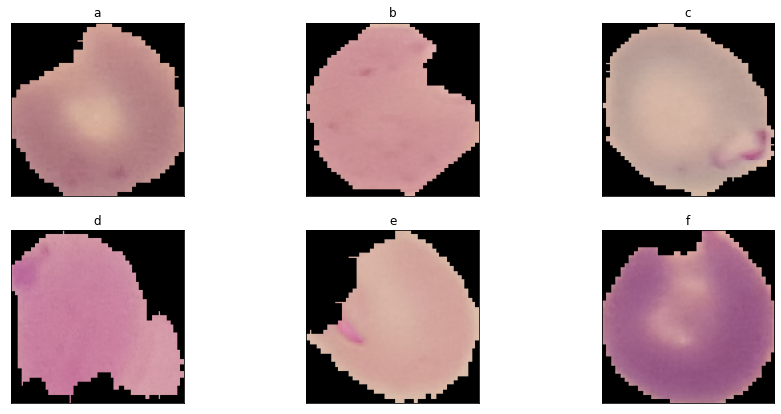

In [23]:
#Parasitized cells incorrectly classified examples
from tensorflow.keras.preprocessing import image

file_list = os.listdir("cell_images/test/parasitized")
file_index = 0
file_list_len = len(file_list)
mismatch_not_found = 1
n_found = 0
n_to_find = 6
idxs = np.zeros(n_to_find)
idxs = idxs.astype('uint32')
misclassified=[]
while n_found < n_to_find:

    while file_index < file_list_len and mismatch_not_found:

        image_filename = file_list[file_index]
        img = ("cell_images/test/parasitized/"+image_filename)

        my_image = image.load_img(img,target_size=image_shape)
        my_image_para = image.img_to_array(my_image)
        my_image_para = np.expand_dims(my_image_para, axis=0)
        predictions = model.predict(my_image_para)
        model_prediction = predictions.item(0)


        if (model_prediction != 0):
            mismatch_not_found = 0
            misclassified.append(file_index)
        else:
            file_index += 1    

    idxs[n_found] = file_index
    #my_image
    file_index += 1
    n_found +=1
    mismatch_not_found = 1
    
    image_filename = file_list[idxs[0]]
img = ("cell_images/test/parasitized/"+image_filename)
my_image1 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs[1]]
img = ("cell_images/test/parasitized/"+image_filename)
my_image2 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs[2]]
img = ("cell_images/test/parasitized/"+image_filename)
my_image3 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs[3]]
img = ("cell_images/test/parasitized/"+image_filename)
my_image4 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs[4]]
img = ("cell_images/test/parasitized/"+image_filename)
my_image5 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs[5]]
img = ("cell_images/test/parasitized/"+image_filename)
my_image6 = image.load_img(img,target_size=image_shape)

plt.figure(1, figsize = (15 , 7))
plt.subplot(2 , 3 , 1)
plt.imshow(my_image1)
plt.title('a')
plt.xticks([]) , plt.yticks([])

plt.subplot(2 , 3 , 2)
plt.imshow(my_image2)
plt.title('b')
plt.xticks([]) , plt.yticks([])

plt.subplot(2, 3 , 3)
plt.imshow(my_image3)
plt.title('c')
plt.xticks([]) , plt.yticks([])

plt.subplot(2 , 3 , 4)
plt.imshow(my_image4)
plt.title('d')
plt.xticks([]) , plt.yticks([])

plt.subplot(2 , 3 , 5)
plt.imshow(my_image5)
plt.title('e')
plt.xticks([]) , plt.yticks([])

plt.subplot(2, 3 , 6)
plt.imshow(my_image6)
plt.title('f')
plt.xticks([]) , plt.yticks([])

plt.show()

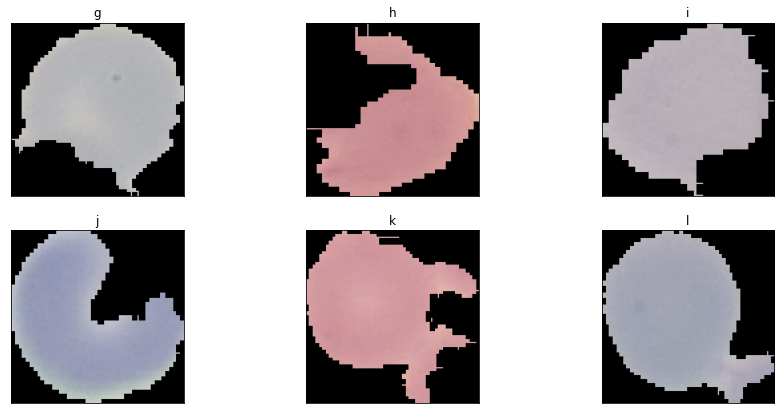

In [24]:
#Uninfected cells incorrectly classified examples
from tensorflow.keras.preprocessing import image

file_list = os.listdir("cell_images/test/uninfected")
file_index = 0
file_list_len = len(file_list)
mismatch_not_found = 1
n_found = 0
n_to_find = 6
idxs_u = np.zeros(n_to_find)
idxs_u = idxs.astype('uint32')
misclassified=[]
while n_found < n_to_find:

    while file_index < file_list_len and mismatch_not_found:

        image_filename = file_list[file_index]
        img = ("cell_images/test/uninfected/"+image_filename)

        my_image = image.load_img(img,target_size=image_shape)
        my_image_para = image.img_to_array(my_image)
        my_image_para = np.expand_dims(my_image_para, axis=0)
        predictions = model.predict(my_image_para)
        model_prediction = predictions.item(0)


        if (model_prediction != 1):
            mismatch_not_found = 0
            misclassified.append(file_index)
        else:
            file_index += 1    

    idxs_u[n_found] = file_index
    #my_image
    file_index += 1
    n_found +=1
    mismatch_not_found = 1
    
image_filename = file_list[idxs_u[0]]
img = ("cell_images/test/uninfected/"+image_filename)
my_image7 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs_u[1]]
img = ("cell_images/test/uninfected/"+image_filename)
my_image8 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs_u[2]]
img = ("cell_images/test/uninfected/"+image_filename)
my_image9 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs_u[3]]
img = ("cell_images/test/uninfected/"+image_filename)
my_image10 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs_u[4]]
img = ("cell_images/test/uninfected/"+image_filename)
my_image11 = image.load_img(img,target_size=image_shape)

image_filename = file_list[idxs_u[5]]
img = ("cell_images/test/uninfected/"+image_filename)
my_image12 = image.load_img(img,target_size=image_shape)

plt.figure(1, figsize = (15 , 7))
plt.subplot(2 , 3 , 1)
plt.imshow(my_image7)
plt.title('g')
plt.xticks([]) , plt.yticks([])

plt.subplot(2 , 3 , 2)
plt.imshow(my_image8)
plt.title('h')
plt.xticks([]) , plt.yticks([])

plt.subplot(2, 3 , 3)
plt.imshow(my_image9)
plt.title('i')
plt.xticks([]) , plt.yticks([])

plt.subplot(2 , 3 , 4)
plt.imshow(my_image10)
plt.title('j')
plt.xticks([]) , plt.yticks([])

plt.subplot(2 , 3 , 5)
plt.imshow(my_image11)
plt.title('k')
plt.xticks([]) , plt.yticks([])

plt.subplot(2, 3 , 6)
plt.imshow(my_image12)
plt.title('l')
plt.xticks([]) , plt.yticks([])
 
plt.show()

# Holdout Set

Finally, the model was tested on the two held-out images, and the model correctly classified both images. First is a parasitized cell and was correctly identified as 0 (parasitized). Second is an uninfected cell, which was also correctly classified as 1 (uninfected).

In [25]:
test_image_gen.class_indices

{'Parasitized': 0, 'Uninfected': 1}

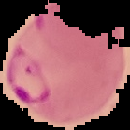

In [26]:
new_image1 = 'cell_images/single_prediction/Parasitised.png'
from tensorflow.keras.preprocessing import image
my_image_para = image.load_img(new_image1,target_size=image_shape)
my_image_para

In [27]:
my_image_para = image.img_to_array(my_image_para)
my_image_para = np.expand_dims(my_image_para, axis=0)
model.predict(my_image_para)

array([[0.]], dtype=float32)

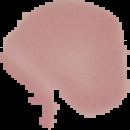

In [28]:
new_image2 = 'cell_images/single_prediction/Uninfected.png'
from tensorflow.keras.preprocessing import image
my_image_uninfected = image.load_img(new_image2,target_size=image_shape)
my_image_uninfected

In [29]:
my_image_uninfected = image.img_to_array(my_image_uninfected)
my_image_uninfected = np.expand_dims(my_image_uninfected, axis=0)
model.predict(my_image_uninfected)

array([[1.]], dtype=float32)

In [30]:
from tensorflow.keras.models import load_model
model.save('malaria_cnn.h5')